# Figure 4. ALTERNATE2 Dynamics of adult mosquito population after 5 week of suppression all 50% efficacy

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import os

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO=0.5  # rate that eggs hatch into larvae
alphaL=0.18  # rate that larvae pupate
alphaP=1  # rate that pupae eclose
phi=500*(1/14)    # number eggs laid per mosquito per day
muO=0.01    # daily death rate of eggs
muL=0.1*alphaL    # daily death rate of larvae
muP=0.1*alphaP     # pupae death rate
muM=1/14     # adult mosquito death rate
muF=1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA=1   # determines the density at which mortality remains proportionate
BB=0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI=0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT=0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c=0.5      # mating competitiveness of released wolbachia males
cv = 1 #0.128   #coverage of adulticide - 0.128 recovers 80% within 3 weeks from one pulse
e=1.2      # relative mortality of wolbachia adults compared to wild adults
RR=0.02915       # release ratio of wolbachia eggs to wild type eggs
RRsupp=1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0=15947.608023052446
OW0=0
rOW0=0
OS0=0
L0=40271.71074193975
LW0=0
rLW0=0
LS0=0
P0=32.67541200187585
PW0=0
rPW0=0
PS0=0
M0=228.72754035145144
MW0=0
MS0=0
F0=228.72754035145144
FW0=0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0
        
RRsupp = 10.5

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

    
#RRsupp = 10.7 #1.865

In [7]:
# Environmental management

start_em=193
stop_em=200
em_eff= 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv=193
stop_lv=200
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

# to reach a new equilibrium:
# based on pupae being 99 at eq - 80% 19.8 / 50% 49.5 / 20% 79.2 / 44% 65.34 / 70% 29.7
# default 1 / 19.2(80%) / 7.6(50%) / 2.97(20%) / 6.42(44% literature) / 5.8(70% old)
# parameter that kills proportion of pupae (wild and wol)

# based on pupae being 33 at eq - 44% = 4.03

In [9]:
# Adulticide

h = start_wol

def ad(t):    
    ad_eff = 0 #4.9 #0.455
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

# NEW efficacy (fixed brackets)
# 4.9 = 90%
    
# efficacy
# 3 = ~90% | 1.9 = ~80% | 1.38 = ~70% | 1.03 = ~60% | 0.77 = ~50%
# 0.56 = ~40% | 0.39 = ~30% | 0.24 = ~20% | 0.11 = ~10%

Model:

In [10]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp + .5*alphaP*PS - muM*1.2*MS
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [11]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [12]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression and Wolbachia functions are switched off:
(should see horizontal lines)

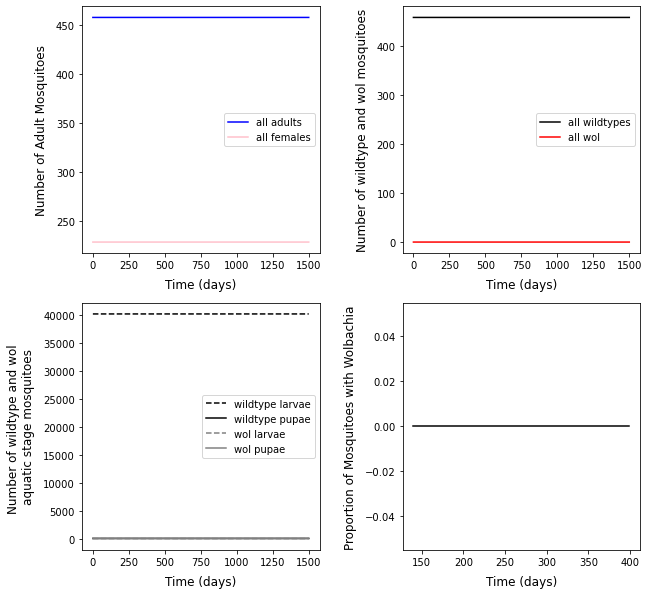

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

### 2. One week of suppression

In [14]:
filepath = os.path.abspath(os.getcwd())

IIT:

In [15]:
IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')
print(IIT_df)

   Unnamed: 0  Target efficacy  Achieved efficacy  RRsupp value  \
0           0             20.0          19.979565         0.155   
1           1             50.0          49.950855         0.640   
2           2             80.0          79.952078         3.054   
3           3             60.0          59.969591         1.152   

   Maximum delayed efficacy  
0                       NaN  
1                       NaN  
2                       NaN  
3                 63.276652  


In [16]:
# switch on

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] #10.5

In [17]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [18]:
# save results
IIT_1w_wild = M+F
IIT_1w_all = M+F+MW+FW+MS
IIT_1w_fem = F+FW
IIT_1w_mal = M+MW+MS

In [19]:
# switch off again

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

SIT:

In [20]:
SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')

SIT_df

,Unnamed: 0,Target efficacy,Achieved efficacy,RRsupp value
0,0,20,19.997650,0.305
1,1,50,49.959542,1.236
2,2,80,79.951665,5.360


In [21]:
# switch on

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]
    
    
#RRsupp = 10.65 #1.865

In [22]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [23]:
# save results
SIT_1w_wild = M+F
SIT_1w_all = M+F+MW+FW+MS
SIT_1w_fem = F+FW
SIT_1w_mal = M+MW+MS

In [24]:
# switch off again

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

RIDL:

In [25]:
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')

RIDL_df

,Unnamed: 0,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,0,20.0,19.960353,0.104,NaN
1,1,50.0,50.013914,0.346,NaN
2,2,80.0,79.967717,0.950,NaN
3,3,45.0,44.998185,0.305,46.117523


In [26]:
# switch on

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

#RRsupp = 1.865

In [27]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [28]:
# save results
RIDL_1w_wild = M+F
RIDL_1w_all = M+F+MW+FW+MS
RIDL_1w_fem = F+FW
RIDL_1w_mal = M+MW+MS

In [29]:
# switch off again

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

Environmental management:

In [30]:
EM_df = pd.read_csv(f'{filepath}/EM_df.csv')
EM_df

,Unnamed: 0,Target efficacy,Efficacy parameter
0,0,20.0,0.800
1,1,50.0,0.500
2,2,80.0,0.200
3,3,47.4,0.526


In [31]:
# switch on

start_em=start_wol-(7*5)
stop_em=start_wol

EM_df = pd.read_csv(f'{filepath}/EM_df.csv')
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 50, 'Efficacy parameter'])
em_eff = em_eff[0]

#em_eff=0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [32]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [33]:
# save results
EM_1w_wild = M+F
EM_1w_all = M+F+MW+FW+MS

In [34]:
# switch off again

start_em=start_wol-(7*5)
stop_em=start_wol
em_eff=1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

Larvicides:

In [35]:
LV_df = pd.read_csv(f'{filepath}/LV_df.csv')
LV_df

,Unnamed: 0,Target efficacy,Model efficacy,Efficacy parameter
0,0,20,19.957080,1.777
1,1,45,43.952347,3.125
2,2,50,49.960003,3.582
3,3,80,79.952713,7.803


In [36]:
# switch on

start_lv=start_wol-(7*5)
stop_lv=start_wol

LV_df = pd.read_csv(f'{filepath}/LV_df.csv')
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 50, 'Efficacy parameter'])
lv_eff = lv_eff[0]

#lv_eff= 5.93

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [37]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [38]:
# save results
LV_1w_wild = M+F
LV_1w_all = M+F+MW+FW+MS

In [39]:
# switch off again

start_lv=start_wol-(7*5)
stop_lv=start_wol
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

Adulticides:

In [40]:
AD_df = pd.read_csv(f'{filepath}/AD_df.csv')
AD_df

,Unnamed: 0,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,0,20,19.975564,0.241,1.000
1,1,50,49.981922,0.764,1.000
2,2,80,79.962323,1.893,1.000
3,3,95,94.950410,5.549,0.113


In [41]:
# switch on

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

AD_df = pd.read_csv(f'{filepath}/AD_df.csv')
    
def ad(t):    
    
    ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 50, 'Efficacy parameter'])
    ad_eff = ad_eff[0]

#    ad_eff = 0 #4.9 #0.455
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01: # and round(t) < h[5]:
        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff
    
#cv = list(AD_df.loc[AD_df['Target efficacy'] == 95, 'Coverage value'])
#cv = cv[0]

In [42]:
# run model
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

In [43]:
# save results
AD_1w_wild = M+F
AD_1w_all = M+F+MW+FW+MS

In [44]:
# switch off again

h = 193

def ad(t):    
    ad_eff = 0 #4.9
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

### 3. Plot results
Total mosquito population:

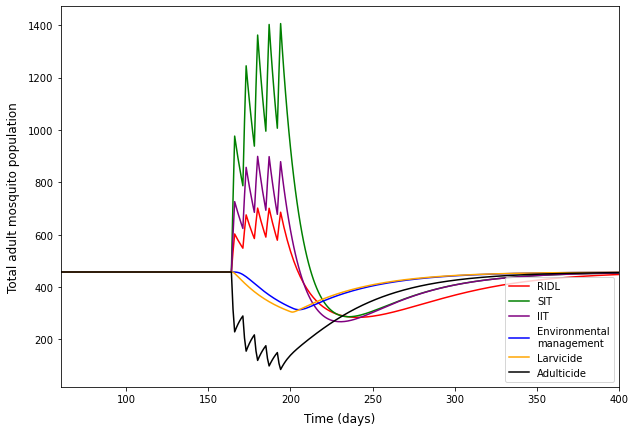

In [45]:
fig, ax1 = plt.subplots(figsize=(10,7))

#plt.axhline(y=457,color="black",label="No suppression")
#plt.axvline(x=107,color="grey",linestyle="solid")

ax1.plot(t,RIDL_1w_all,color='red',label="RIDL")
ax1.plot(t,SIT_1w_all,color='green',label="SIT")
ax1.plot(t,IIT_1w_all,color='purple',label="IIT")
ax1.plot(t,EM_1w_all,color='blue',label="Environmental\nmanagement")
ax1.plot(t,LV_1w_all,color='orange',label="Larvicide")
ax1.plot(t,AD_1w_all,color='black',label="Adulticide")

ax1.set_xlim(60,400)
#ax1.set_ylim(0,900)
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Total adult mosquito population",fontsize=12, labelpad=8)
ax1.legend(loc='lower right')
#ax1.set_title("Mosquito population dynamics under 1 week of suppression")
#plt.savefig('suppression_compare_1wk_11.8.22.png', dpi=600, bbox_inches='tight',)

Female mosquito population: (included in publication)

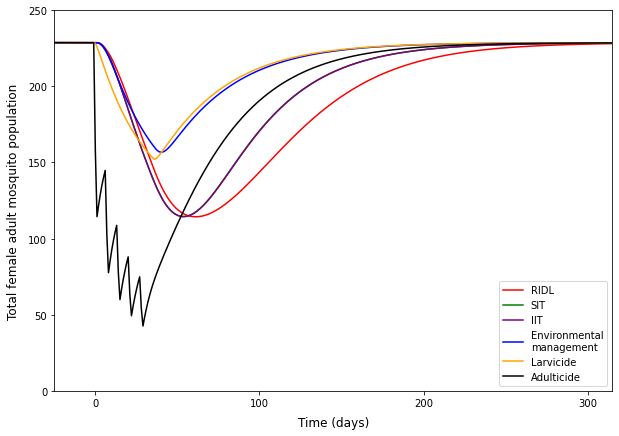

In [46]:
fig, ax1 = plt.subplots(figsize=(10,7))

#plt.axhline(y=457,color="black",label="No suppression")
#plt.axvline(x=107,color="grey",linestyle="solid")

ax1.plot(t,RIDL_1w_fem,color='red',label="RIDL")
ax1.plot(t,SIT_1w_fem,color='green',label="SIT")
ax1.plot(t,IIT_1w_fem,color='purple',label="IIT")
ax1.plot(t,EM_1w_all/2,color='blue',label="Environmental\nmanagement")
ax1.plot(t,LV_1w_all/2,color='orange',label="Larvicide")
ax1.plot(t,AD_1w_all/2,color='black',label="Adulticide")

ax1.set_xlim(140,480)
ax1.set_ylim(0,250)
plt.xticks([165,265,365,465],[0,100,200,300])#,rotation=20)
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Total female adult mosquito population",fontsize=12, labelpad=8)
ax1.legend(loc='lower right')
#ax1.set_title("Mosquito population dynamics under 1 week of suppression")
#plt.savefig('suppression_compare_1wk_17.8.22_female.png', dpi=600, bbox_inches='tight',)

Male mosquito population:

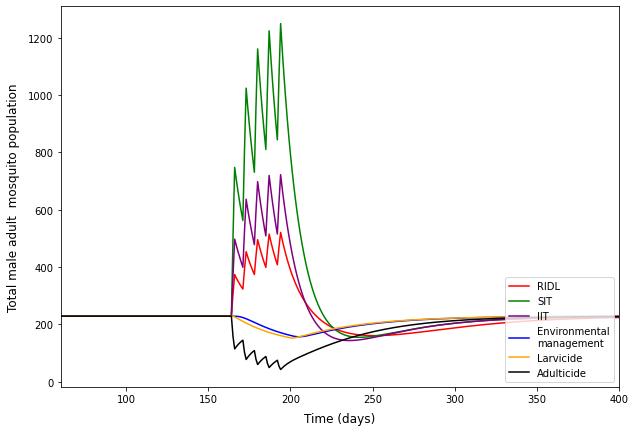

In [47]:
fig, ax1 = plt.subplots(figsize=(10,7))

#plt.axhline(y=457,color="black",label="No suppression")
#plt.axvline(x=107,color="grey",linestyle="solid")

ax1.plot(t,RIDL_1w_mal,color='red',label="RIDL")
ax1.plot(t,SIT_1w_mal,color='green',label="SIT")
ax1.plot(t,IIT_1w_mal,color='purple',label="IIT")
ax1.plot(t,EM_1w_all/2,color='blue',label="Environmental\nmanagement")
ax1.plot(t,LV_1w_all/2,color='orange',label="Larvicide")
ax1.plot(t,AD_1w_all/2,color='black',label="Adulticide")

ax1.set_xlim(60,400)
#ax1.set_ylim(0,700)
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Total male adult  mosquito population",fontsize=12, labelpad=8)
ax1.legend(loc='lower right')
#ax1.set_title("Mosquito population dynamics under 1 week of suppression")
#plt.savefig('suppression_compare_1wk_11.8.22_male.png', dpi=600, bbox_inches='tight',)